# DCAPE and DCIN

Thomas Schanzer z5310829  
School of Physics, UNSW  
October 2021

In this notebook, we implement DCAPE and DCIN calculations.

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '12'

from scipy.optimize import minimize_scalar, root_scalar
from scipy.integrate import simps

import metpy.calc as mpcalc
from metpy.units import units
from metpy.units import concatenate
from metpy.plots import SkewT
import metpy.constants as const

import sys

sys.path.append('../scripts/')
from environment import Environment
from thermo import moist_lapse, theta_e, theta_w

# Literature

**Gilmore and Wicker (1998)** use
$$\mathrm{DCAPE} = g \int_{z_\mathrm{sfc}}^{z_n} \frac{\theta_\mathrm{env}(z) - \theta_\mathrm{p}(z)}{\theta_\mathrm{env}(z)} ~\mathrm{d}z$$
where $z_\mathrm{sfc}$ and $z_n$ are the surface and parcel origin heights respectively. The parcel begins at the wet bulb temperature and follows a moist adiabat. Following **Brancato (1942)** and **Rasmussen (1994)** they take $z_n$ to be the height of minimum $\theta_w$ in the lowest 6 km of the environment. They intentionally neglect the virtual temperature correction.

**Savvidou *et. al.* (2010)** integrate the buoyancy itself between the level of free sink and the surface:
$$\mathrm{DCAPE} = - \int_{p_f}^{p_s} \alpha_p - \alpha_\mathrm{env} ~\mathrm{d}p.$$

**Market *et. al.* (2017)** modify the definition of Gilmore and Wicker:
$$\mathrm{DCAPE} = g \int_{z_\mathrm{nb}}^{z_n} \frac{\theta_\mathrm{v,env}(z) - \theta_\mathrm{v,p}(z)}{\theta_\mathrm{v,env}(z)} ~\mathrm{d}z,$$
using virtual potential temperatures and using the neutral buoyancy level as the lower integration bound. They take $z_n$ to be the height of minimum $T_w$ in the lowest 6 km of the environment. They also define
$$\mathrm{DCIN} = g \int_{z_\mathrm{sfc}}^{z_\mathrm{nb}} \frac{\theta_\mathrm{v,env}(z) - \theta_\mathrm{v,p}(z)}{\theta_\mathrm{v,env}(z)} ~\mathrm{d}z.$$

We will follow **Market *et. al.* (2017)**, but since $\theta_v = (p_0/p)^\kappa T_v$ and the parcel and environment are always at the same pressure, we use
$$\mathrm{DCAPE} = g \int_{z_\mathrm{nb}}^{z_n} \frac{T_\mathrm{v,env}(z) - T_\mathrm{v,p}(z)}{T_\mathrm{v,env}(z)} ~\mathrm{d}z$$
and
$$\mathrm{DCIN} = g \int_{z_\mathrm{sfc}}^{z_\mathrm{nb}} \frac{T_\mathrm{v,env}(z) - T_\mathrm{v,p}(z)}{T_\mathrm{v,env}(z)} ~\mathrm{d}z.$$

Question: what if there are multiple neutral buoyancy levels?

# Implementation

In [5]:
file = '../soundings/SYDNEY AIRPORT (94767) 16 Jul 2021 00Z.txt'
sounding = pd.read_csv(
    file, names=['pressure', 'height', 'temperature', 'dewpoint'],
    usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
height = sounding[:,1]*units.meter
temperature = sounding[:,2]*units.celsius
dewpoint = sounding[:,3]*units.celsius
sydney = Environment(
    pressure, height, temperature, dewpoint,
    info='SYDNEY AIRPORT (94767) 16 Jul 2021 00Z', name='Sydney')

In [157]:
file = '../soundings/SYDNEY AIRPORT (94767) 12 Nov 2019 00Z.txt'
sounding = pd.read_csv(
    file, names=['pressure', 'height', 'temperature', 'dewpoint'],
    usecols=[0, 1, 2, 3], header=0)
sounding = sounding.to_numpy()
pressure = sounding[:,0]*units.mbar
height = sounding[:,1]*units.meter
temperature = sounding[:,2]*units.celsius
dewpoint = sounding[:,3]*units.celsius
sydney_dry = Environment(
    pressure, height, temperature, dewpoint,
    info='SYDNEY AIRPORT (94767) 12 Nov 2019 00Z', name='Sydney')

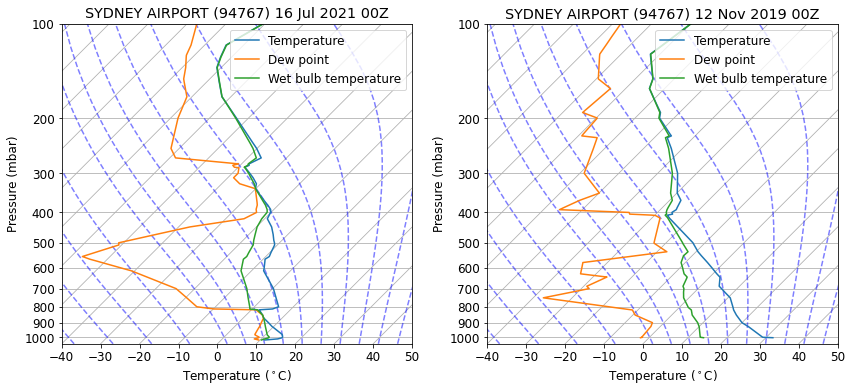

In [165]:
fig = plt.figure(figsize=(12,8))
for i, sounding in enumerate([sydney, sydney_dry]):
    skew = SkewT(fig, subplot=(1,2,i+1), rotation=45)
    skew.plot(sounding._pressure_raw, sounding._temperature_raw, label='Temperature')
    skew.plot(sounding._pressure_raw, sounding._dewpoint_raw, label='Dew point')
    skew.plot(
        sounding._pressure_raw,
        concatenate([sounding.wetbulb_temperature(z) for z in sounding._height_raw]),
        label='Wet bulb temperature')
    skew.plot_moist_adiabats()
    skew.ax.legend()
    skew.ax.set(
        xlabel=r'Temperature ($^\circ$C)',
        ylabel='Pressure (mbar)',
        title=sounding.info)
fig.tight_layout()
plt.show()

In [189]:
def dcape_dcin(sounding, samples=10000):
    """
    Computes DCAPE and DCIN for a sounding according to Market et. al. (2017).
    
    Args:
        sounding: An Environment object.
        samples: Number of samples to use for integration (optional).
    
    Returns:
        DCAPE and DCIN for the sounding.
    """
    
    # find minimum wet bulb temperature in lowest 6 km
    wetbulb = lambda z: sounding.wetbulb_temperature(
        z*units.meter).m_as(units.kelvin)
    sol = minimize_scalar(wetbulb, bounds=(0, 6000), method='bounded')
    z_initial = sol.x
    p_initial = sounding.pressure(z_initial*units.meter)
    t_initial = sol.fun*units.kelvin
    
    def integrand(z_final):
        z_final = z_final*units.meter
        p_final = sounding.pressure(z_final)
        t_final = moist_lapse(p_final, t_initial, p_initial)
        w_final = mpcalc.saturation_mixing_ratio(p_final, t_final)
        tv_final = mpcalc.virtual_temperature(t_final, w_final)
        
        t_env = sounding.temperature(z_final)
        w_env = mpcalc.mixing_ratio_from_specific_humidity(
            sounding.specific_humidity(z_final))
        tv_env = mpcalc.virtual_temperature(t_env, w_env)
        
        result = 1 - tv_final.m_as(units.kelvin)/tv_env.m_as(units.kelvin)
        return result
    
    # check whether a neutral buoyancy level exists
    if np.min(integrand(np.linspace(0, z_initial, 6000))) > 0:
        # no neutral buoyancy level, integrate from surface for DCAPE
        z_dcape = np.linspace(0, z_initial, samples)
        dcape = simps(integrand(z_dcape), z_dcape)*units.meter*const.g
        return dcape, 0*units.meter**2/units.second**2  # DCIN == 0
    else:
        # create an interval [x0, x0 + 10] and shift until f(x0)
        # and f(x0 + 10) have different signs
        x0 = z_initial - 10
        while integrand(x0)*integrand(x0 + 10) > 0:
            x0 -= 10
    
    # find neutral buoyancy level (integrand == 0)
    nb_level = root_scalar(
        integrand, bracket=[x0, x0 + 10], method='brentq').root
    
    # DCAPE: integrate from neutral buoyancy level to min. wetbulb level
    z_dcape = np.linspace(nb_level, z_initial, samples)
    dcape = simps(integrand(z_dcape), z_dcape)*units.meter*const.g
    # DCIN: integrate from surface to neutral buoyancy level
    z_dcin = np.linspace(0, nb_level, samples)
    dcin = simps(integrand(z_dcin), z_dcin)*units.meter*const.g
    
    return dcape, dcin

In [190]:
%%time
dcape_dcin(sydney)

CPU times: user 6.81 s, sys: 29.4 ms, total: 6.84 s
Wall time: 6.87 s


(121.24732603817789 <Unit('meter ** 2 / second ** 2')>,
 -455.7193781276219 <Unit('meter ** 2 / second ** 2')>)

In [191]:
%%time
dcape_dcin(sydney_dry)

CPU times: user 529 ms, sys: 7.2 ms, total: 537 ms
Wall time: 540 ms


(1099.8558337746756 <Unit('meter ** 2 / second ** 2')>,
 0.0 <Unit('meter ** 2 / second ** 2')>)